# Final Notebook for Group 52
### Kenny Han, CJ Reamer, Carly Bowen

In [33]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

/opt/anaconda3/envs/cmpinf0010/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/anaconda3/envs/cmpinf0010/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/anaconda3/envs/cmpinf0010/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")
/opt/anaconda3/envs/cmpinf0010/lib/python3.12/site-packages/geopandas/io/file.py:399: FutureWarning: errors='

                neighborhood  count
0               East Liberty    9.0
1  Central Business District    7.0
2                  Beechview    7.0
3          South Side Slopes    7.0
4              South Oakland    6.0
5                  Hazelwood    6.0
6               Point Breeze    6.0
7           Mount Washington    6.0
8                   Sheraden    5.0
9        Squirrel Hill South    5.0


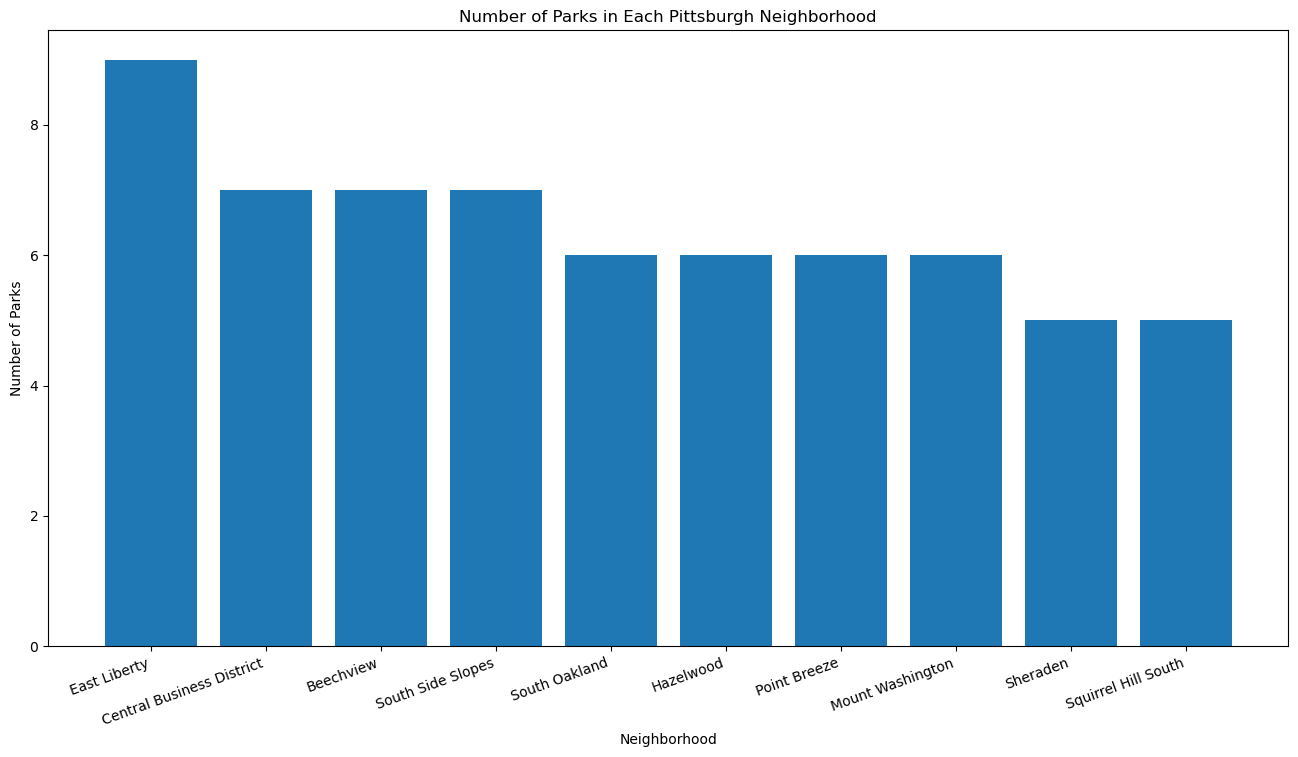

In [49]:


neighborhoods = gpd.read_file('data/neighborhoods.geojson')  
parks = gpd.read_file('data/parks.geojson')  

if 'geometry' not in parks.columns:
    parks['geometry'] = parks.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis=1)
    parks = gpd.GeoDataFrame(parks, geometry='geometry', crs="EPSG:4326") 

parks = parks.to_crs(neighborhoods.crs)

parks_with_neighborhoods = gpd.sjoin(parks, neighborhoods, how="left", op="within")
park_counts = parks_with_neighborhoods.groupby('hood').size().reset_index(name='park_count')

parks_with_neighborhoods.to_file("parks_with_neighborhoods.geojson", driver="GeoJSON")
parks_with_neighborhoods[['origpkname', 'hood']].to_csv("parks_with_neighborhoods.csv", index=False)

all_neighborhoods = neighborhoods[['hood']]
park_counts_full = all_neighborhoods.merge(park_counts, on='hood', how='left').fillna({'park_count': 0})
park_counts_sorted = park_counts_full.sort_values(by='park_count', ascending=False).reset_index(drop=True)
park_counts_sorted.rename(columns={'hood': 'neighborhood' , 'park_count': 'count'}, inplace=True)
file_path = "final_metrics/sorted_park_counts_by_neighborhood.csv"
park_counts_sorted.to_csv(file_path, index=False)

print(park_counts_sorted.head(10))

plt.figure(figsize=(16, 8))
plt.bar(park_counts_sorted.head(10)['neighborhood'], park_counts_sorted.head(10)['count'])
plt.title('Number of Parks in Each Pittsburgh Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Parks')
plt.xticks(rotation=20, ha='right')

plt.show()

                neighborhood  count
0        Squirrel Hill South   5073
1              Highland Park   2941
2        Squirrel Hill North   2083
3           South Side Flats   1693
4                  Shadyside   1558
5                 Bloomfield   1436
6               East Liberty   1366
7               Point Breeze   1316
8                Perry North   1007
9  Central Business District   1002


/var/folders/sl/ryrf9ly97sd8vdp_pckk6yrw0000gn/T/ipykernel_45811/3542500751.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  tree_data = pd.read_csv("data/trees.csv", index_col="_id")


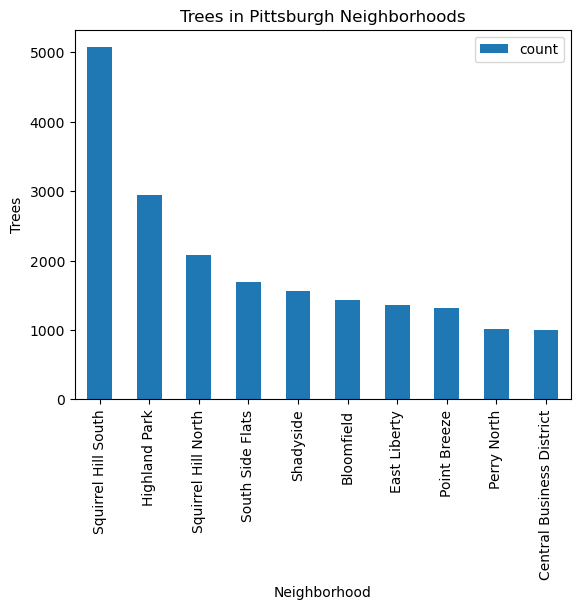

In [35]:
tree_data = pd.read_csv("data/trees.csv", index_col="_id")
tree_data.head(5)
tally = tree_data['neighborhood'].value_counts().rename_axis('neighborhood').reset_index(name='count')

print(tally.head(10))

sorted = tally.sort_values(by='count', ascending=False)

file_path = 'final_metrics/sorted_trees_counts_by_neighborhood.csv'
sorted.to_csv(file_path, index=False)

df = pd.DataFrame(tally).head(10)

df.plot(x='neighborhood', y='count', kind='bar')
plt.title('Trees in Pittsburgh Neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Trees')
plt.show()

          neighborhood  count
0  Squirrel Hill South     14
1        Highland Park     12
2           Bloomfield      8
3     Allegheny Center      8
4      Terrace Village      8
5            Brookline      8
6         Point Breeze      7
7          Perry North      7
8         East Liberty      6
9     Brighton Heights      6


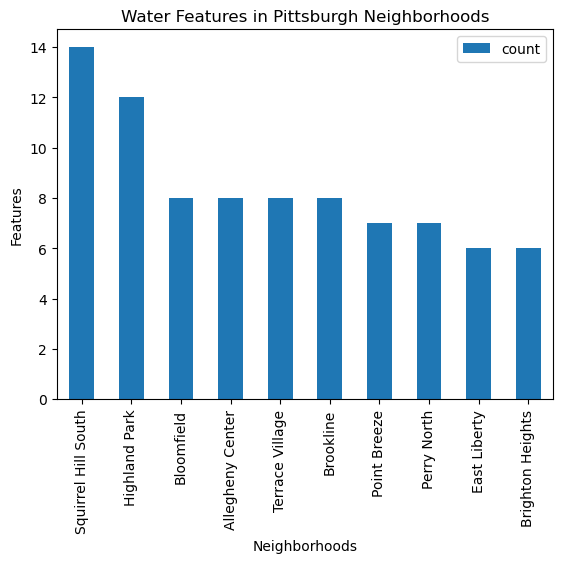

In [36]:
water_features = pd.read_csv("data/water_features.csv", index_col="_id")
water_features.head(10)

count = water_features['neighborhood'].value_counts().rename_axis('neighborhood').reset_index(name='count')
print(count.head(10))
sorted = count.sort_values(by='count', ascending=False)
file_path = 'final_metrics/sorted_water_counts_by_neighborhood.csv'
sorted.to_csv(file_path, index=False)

ft = pd.DataFrame(count).head(10)
ft.plot(x='neighborhood', y='count', kind='bar')
plt.title('Water Features in Pittsburgh Neighborhoods')
plt.xlabel('Neighborhoods')
plt.ylabel('Features')
plt.show()

In [37]:
sorted_parks = pd.read_csv("final_metrics/sorted_park_counts_by_neighborhood.csv")
sorted_trees = pd.read_csv("final_metrics/sorted_trees_counts_by_neighborhood.csv")
sorted_water = pd.read_csv("final_metrics/sorted_water_counts_by_neighborhood.csv")

In [48]:
sorted_parks['park_rank'] = sorted_parks.index + 1
sorted_trees['tree_rank'] = sorted_trees.index + 1
sorted_water['water_rank'] = sorted_water.index + 1
combined_ranks = sorted_parks.merge(sorted_trees[['neighborhood', 'count', 'tree_rank']], on='neighborhood', how='outer', suffixes=('_parks', '_trees')
)
combined_ranks = combined_ranks.merge(sorted_water[['neighborhood', 'count', 'water_rank']], on='neighborhood', how='outer', suffixes=('', '_water')
)
combined_ranks = combined_ranks.fillna({'park_rank': 0, 'tree_rank': 0, 'water_rank': 0, 'counts_parks': 0, 'counts_trees': 0, 'counts': 0})

combined_ranks['average_rank'] = (combined_ranks['park_rank'] + combined_ranks['tree_rank'] + combined_ranks['water_rank']) / 3

combined_ranks_sorted = combined_ranks.sort_values(by='average_rank').reset_index(drop=True)

file_path = "final_metrics/combined_average_rankings_by_neighborhood.csv"
combined_ranks_sorted.to_csv(file_path, index=False)
top_10 = combined_ranks_sorted.head(10)

print(top_10)

plt.figure(figsize=(12, 8))
plt.bar(top_10['neighborhood'], top_10['average_rank'],  color='orange')
plt.title('Top 5 Neighborhoods by Average Rank')
plt.xlabel('Neighborhood')
plt.ylabel('Average Rank')
plt.xticks(rotation=20, ha='right')

plt.show()

                neighborhood  count_parks  park_rank  count_trees  tree_rank  \
0        Squirrel Hill South          5.0         10         5073          1   
1               Point Breeze          6.0          7         1316          8   
2               East Liberty          9.0          1         1366          7   
3                 Bloomfield          3.0         16         1436          6   
4  Central Business District          7.0          2         1002         10   
5           Mount Washington          6.0          8          874         12   
6           South Side Flats          5.0         11         1693          4   
7           Brighton Heights          4.0         12          910         11   
8                  Beechview          7.0          3          611         24   
9                  Brookline          2.0         36          853         14   

   count  water_rank  average_rank  
0   14.0         1.0      4.000000  
1    7.0         7.0      7.333333  
2    6.0

### Kenny
The best neighborhood overall was Squirrel Hill South. It had the lowest overall average rank, bascially the average rank of that neighborhood for the three metric (parks, water, trees); its park rank was **rank 10**, tree rank was **rank 1**, and water rank was also **rank 1** giving it a average rank of **4** which was the lowest and thus the best based on our overall metric. This metric does not weigh in the actual values of the number of trees, parks, water features, but how neighborhoods they place relative to each other, so if the first ranked neighborhood beats all the rest other by 1,000,000,000 that would not be shown. But this also makes it resilient to bias or outliers like that, and keeps into account all the individual metrics equally. There can be personal bias with me choosing to use water, parks, and trees since not everyone may like these when going on a walk.

**Parks only conclusion**

The neighborhood with the most parks is East Liberty with 9 parks. There seems to be a steep drop off from the top neighborhoods and levels off with neighborhoods with 1 and no parks. The neighborhoods with the most parks are close to each other, I think what is happening is that the locations with the most parks are shared by multiple neighborhoods.

### Carly:
As for my metric, trees, Squirrel Hill South had the most trees out of all the other Pittsburgh neighborhoods by a landslide. Squirrel Hill South had around 5,000 trees ranking first place while second place, Highland Park, had around 3,000 tees. Although I’m not entirely familiar with Pittsburgh neighborhoods, I am aware of Squirrel Hill South’s scenery and area as I sometimes visit now and then. I find Squirrel Hill South very relaxing and spacious with Schenley Park and the Phipps Conservatory, thus I’d like to agree with my results for Squirrel Hill South as the best neighborhood.
